# American Put Options with the Binomial Asset Pricing Model 

Implementation of a simple slow and fast american option pricing model in python. We will treat binomial tree as a network with nodes (i,j) with i representing the time steps and j representing the number of ordered price outcome (lowest - or bottom of tree - to highest). 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.stats import bernoulli
from scipy.optimize import fsolve
from scipy.stats import norm
from tabulate import tabulate
%matplotlib inline

# Binomial Tree Representation

Stock tree can be represented using nodes (i,j) and intial stock price S0

S_{i,j} = S_0u^{j}d^{i-j}

C_{i,j} represents contract price at each node (i,j). Where C_{N,j} represents final payoff function that we can define.

# American Option Characteristics

For an american put option: if T = t_N then at the terminal nodes, C^{j}_N = (K-S^{j}_N)^{+}

For all other parts of the tree at nodes (i,j):

- Max of exercise value or continuation/hold value

- C^{j}_i = max[ (K-S^{j}_i)^{+} , exp^{-r\Delta t} { q^{j}_i C^{j+1}_{i+1} + (1 - q^{j}_i)C^{j-1}_{i-1}} ]

In [3]:
# Initialise parameters
S0 = 10000      # initial stock price
K = 10000       # strike price
T = 3         # time to maturity in years
N = 3         # number of time steps
sigma = 0.4  # volatility

dt = T/N
u = np.exp(sigma * np.sqrt(dt))       # up-factor in binomial models
d = 1/u       # ensure recombining tree

opttype = 'C' # Option Type 'C' or 'P'
rates = pd.read_csv('rates_ex.csv')
put_v = pd.read_csv('put_v_ex.csv')
call_v = pd.read_csv('call_v_ex.csv')
coupon = 200 # 액면이자
div = 0

ms_strike = pd.read_csv('conversion_price_ms.csv')
ms_rates = pd.read_csv('ms_rates_1231.csv')


# Stock Tree

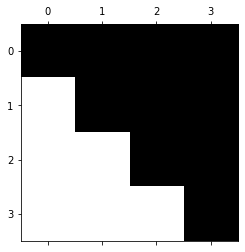

In [4]:
#  Create some empty matrices to hold our stock and call prices.
stock_prices = np.zeros( (N+1, N+1) )

#  Put our initial price in the matrix
stock_prices[0,0] = S0

#  Fill out the remaining values
for i in range(1, N+1 ):
    M = i + 1
    stock_prices[0, i] = u * stock_prices[0, i-1]
    for j in range(1, M ):
        stock_prices[j, i] = d * stock_prices[j - 1, i - 1]
 
plt.spy(stock_prices)

In [5]:
print(tabulate(stock_prices.round(0)))

#DF = pd.DataFrame(stock_prices)
#DF.to_csv("1230_stock_prices_0311.csv")

-----  -----  -----  -----
10000  14918  22255  33201
    0   6703  10000  14918
    0      0   4493   6703
    0      0      0   3012
-----  -----  -----  -----


# Strike Prices Tree

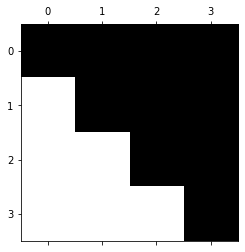

In [6]:
#  Create some empty matrices to hold our stock and call prices.
K_prices = np.zeros( (N+1, N+1) )

# 자체 산출한 값
#  Put our initial price in the matrix
K_prices[0,0] = K
"""
#  Fill out the remaining values
for i in range(0, N+1 ):
    M = i + 1
    if i < 5: # 한 달 동안은 리픽싱을 적용하지 않음
        for j in range(0, M ):
            K_prices[j, i] = K
            
    else:  # 한 달 이후에는 모두 적용됨
        for j in range(0, M ):
            if stock_prices[j, i] <= K:
                K_prices[j, i] = max(stock_prices[j, i], K*70/100)
            else:
                K_prices[j, i] = K
"""

# 기간과 무관하게 동일한 전환가격 적용
for i in range(0, N+1 ):
    M = i + 1
    for j in range(0, M ):
        K_prices[j, i] = K
        
"""
# MS 값 그대로 적용시
for i in range(0, N+1 ):
    M = i + 1
    for j in range(0, M ):
        K_prices[j, i] = ms_strike.iloc[j,i]
"""
plt.spy(K_prices)

In [7]:
print(tabulate(K_prices.round(0)))
#DF = pd.DataFrame(K_prices)
#DF.to_csv("1231_K_prices_0304.csv")

-----  -----  -----  -----
10000  10000  10000  10000
    0  10000  10000  10000
    0      0  10000  10000
    0      0      0  10000
-----  -----  -----  -----


# Put bond price

[0 0 10800 11100]


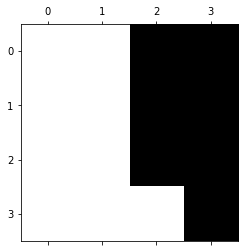

In [8]:
#  Create some empty matrices to hold our stock and call prices.
p_prices = np.zeros( (N+1, N+1) )
put_ar = put_v.iloc[0,1:].to_numpy()
p_interval = 0
print(put_ar)

#  Fill out the remaining values
for i in range(1, N+1):
    M = i + 1
    if i >= 2: # 상환권 행사 가능 이후에만 고려함
        if i == 2: # 상환권 행사할 수 있는 최초 시기
            p_prices[0,i] = put_ar[i] # 다시 바꾸면 put_ar[i]를 put_ar[p_interval]로
            p_interval += 1
            for j in range(1, M ):
                p_prices[j, i] = p_prices[j-1 , i]
        
        elif i % 3 == 0:  # 상환권 행사가 12주 마다 가능함
            p_prices[0,i] = put_ar[i] # 다시 바꾸면 put_ar[i]를 put_ar[p_interval]로
            p_interval += 1
            for j in range(1, M ):
                p_prices[j, i] = p_prices[j-1 , i]
        
plt.spy(p_prices)

In [9]:
print(tabulate(p_prices.round(0)))
#DF = pd.DataFrame(p_prices)
#DF.to_csv("1231_p_prices_0304.csv")

-  -  -----  -----
0  0  10800  11100
0  0  10800  11100
0  0  10800  11100
0  0      0  11100
-  -  -----  -----


# Call bond price

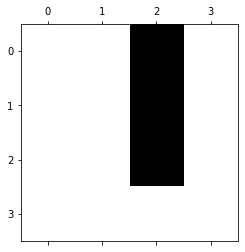

In [10]:
#  Create some empty matrices to hold our stock and call prices.
c_prices = np.zeros( (N+1, N+1) )
call_ar = call_v.iloc[0,1:].to_numpy()
c_interval = 0

#  Fill out the remaining values
for i in range(1, N+1):
    M = i + 1
    if i >= 2: # 상환권 행사 가능 이후에만 고려함
        #if i == 2: # 상환권 행사할 수 있는 최초 시기
        c_prices[0,i] = call_ar[i] # 다시 바꾸면 put_ar[i]를 put_ar[p_interval]로
        #p_interval += 1 예제에서는 그냥 바로 적용하니까 안씀
        for j in range(1, M ):
            c_prices[j, i] = c_prices[j-1 , i]
        
plt.spy(c_prices)

In [11]:
print(tabulate(c_prices.round(0)))
#DF = pd.DataFrame(p_prices)
#DF.to_csv("c_prices.csv")

-  -  -----  -
0  0  10800  0
0  0  10800  0
0  0  10800  0
0  0      0  0
-  -  -----  -


# Interest Rates Trees

---  ---  ---  ---
0.1  0.1  0.1  0.1
0    0.1  0.1  0.1
0    0    0.1  0.1
0    0    0    0.1
---  ---  ---  ---


'\n# 회사제시 값 그대로 적용시\nfor i in range(0, N+1 ):\n    M = i + 1\n    for j in range(0, M ):\n        rf_matrix[j, i] = ms_rates.iloc[j,i]\n'

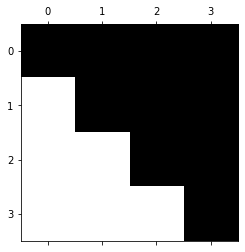

In [12]:
# Forward rate 0행이 rd, 1행이 rf로 구성했음, 초기세팅
rd = rates.iloc[0,1:].to_numpy()
rf = rates.iloc[1,1:].to_numpy()

rd_matrix = np.zeros( (N+1, N+1) )

# rd TF논리대로 적용
rd_matrix[0,0] = rd[0]

for i in range(1, N+1 ):
    M = i + 1
    rd_matrix[0, i] = rd[i]
    for j in range(1, M ):
        rd_matrix[j, i] = rd_matrix[j-1, i]

"""
# 회사제시 값 그대로 적용시
for i in range(0, N+1 ):
    M = i + 1
    for j in range(0, M ):
        rd_matrix[j, i] = ms_rates.iloc[j,i]

"""

plt.spy(rd_matrix)
print(tabulate(rd_matrix.round(4)))
#DF = pd.DataFrame(rd_matrix)
#DF.to_csv("1231_rd_matrix_0304.csv")


rf_matrix = np.zeros( (N+1, N+1) )

# rf TF논리대로 적용
rf_matrix[0,0] = rf[0]

for i in range(1, N+1 ):
    M = i + 1
    rf_matrix[0, i] = rf[i]
    for j in range(1, M ):
        rf_matrix[j, i] = rf_matrix[j - 1, i]

"""
# 회사제시 값 그대로 적용시
for i in range(0, N+1 ):
    M = i + 1
    for j in range(0, M ):
        rf_matrix[j, i] = ms_rates.iloc[j,i]
"""

----  ----  ----  ----
0.02  0.02  0.02  0.02
0     0.02  0.02  0.02
0     0     0.02  0.02
0     0     0     0.02
----  ----  ----  ----


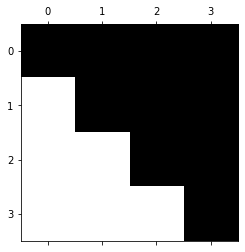

In [13]:
plt.spy(rf_matrix)
print(tabulate(rf_matrix.round(4)))
#DF = pd.DataFrame(rf_matrix)
#DF.to_csv("1231_rf_matrix_0304.csv")

# Q-Value Tree

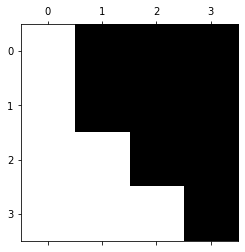

In [14]:
q_value = np.zeros( (N+1, N+1) )

# 본래 변동되는 rf를 기준으로 계산한 q 값
#  Fill out the remaining values
for i in range(1, N+1 ):
    M = i + 1
    q_value[0, i] = (np.exp(rf_matrix[0,i]*dt) - d)/(u-d)
    for j in range(1, M ):
        q_value[j, i] = (np.exp(rf_matrix[j,i]*dt) - d)/(u-d)
"""
for i in range(0, N+1 ):
    M = i + 1
    for j in range(0, M ):
        q_value[j, i] = ms_q_value.iloc[j,i]
"""

plt.spy(q_value)

In [15]:
print(tabulate(q_value.round(4)))
#DF = pd.DataFrame(q_value)
#DF.to_csv("1231_q_value_0304_2.csv")

-  ------  ------  ------
0  0.4259  0.4259  0.4259
0  0.4259  0.4259  0.4259
0  0       0.4259  0.4259
0  0       0       0.4259
-  ------  ------  ------


# Equity Value & Debt Value & Holding Value & Convertible Bond

In [25]:
# 만기 시점 가치 각각 세팅
eq_value = np.zeros( (N+1, N+1) )
for i in range(0, N+1):
    if stock_prices[i, N] > p_prices[i, N]:
        eq_value[i, N] = (stock_prices[i, N]*K)/K_prices[i, N]
    else:
        eq_value[i, N] = 0

db_value = np.zeros( (N+1, N+1) )
for i in range(0, N+1):
    if stock_prices[i, N] > p_prices[i, N]:
        db_value[i, N] = 0
    else:
        db_value[i, N] = p_prices[i, N]

hp_value = np.zeros( (N+1, N+1) )
for i in range(0, N+1):
    hp_value[i, N] = eq_value[i, N] + db_value[i, N]


cb_value = np.zeros( (N+1, N+1) )
for i in range(0, N+1):
    if c_prices[i, N] != 0: cb_value[i,N] = max(min(hp_value[i,N], c_prices[i,N]), (stock_prices[i,N]*K)/K_prices[i,N], p_prices[i,N]) # Callable option이 있을 때만 활성화
    else: cb_value[i, N] = max(hp_value[i,N], (stock_prices[i,N]*K)/K_prices[i,N], p_prices[i,N]) # call 없을 때 적용 가격


#  Fill out the remaining values
for i in range( N-1, -1, -1 ):
    for j in range( 0, i+1 ):
        if i==0 and j==0: coupon = 0 # 기초에는 coupon을 받지 않음
        # Holding Value 먼저 계산해줌
        hp_value[j, i] = ( eq_value[j,i+1]*q_value[j,i+1] + eq_value[j+1,i+1]*(1-q_value[j+1,i+1]) )*np.exp(-rf_matrix[j+1,i+1]*dt)+ \
                         ( db_value[j,i+1]*q_value[j,i+1] + db_value[j+1,i+1]*(1-q_value[j+1,i+1]) )*np.exp(-rd_matrix[j+1,i+1]*dt)+  coupon
        # 계산된 Holding Value기준으로 최종가치산출
        if c_prices[j, i] != 0: cb_value[j, i] = max(min(hp_value[j,i], c_prices[j, i]), (stock_prices[j,i]*K)/K_prices[j,i], p_prices[j,i]) # Callable option이 있을 때만 활성화
        else: cb_value[j, i] = max(hp_value[j,i], (stock_prices[j,i]*K)/K_prices[j,i], p_prices[j,i]) # call 없을 때 적용 가격
        
        # Equity Value 산출, 앞서 계산된 최종가치에 따라 값이 변동 됨: 주식가치 - 주식가치/ 조기상환 등 - 0/ Holding Value - Equity Value의 이전 노드 할인금액
        if cb_value[j, i] == (stock_prices[j,i]*K)/K_prices[j,i]:
            eq_value[j, i] = (stock_prices[j,i]*K)/K_prices[j,i]
        elif cb_value[j, i] == hp_value[j,i]:
            eq_value[j, i] = ( eq_value[j,i+1]*q_value[j,i+1] + eq_value[j+1,i+1]*(1-q_value[j+1,i+1]) )*np.exp(-rf_matrix[j+1,i+1]*dt)
        else:
            eq_value[j, i] = 0
        
        # Debt Value 산출, Equity Value와 반대
        if cb_value[j, i] == (stock_prices[j,i]*K)/K_prices[j,i]:
            db_value[j, i] = 0
        elif cb_value[j, i] == hp_value[j, i]:
            db_value[j, i] = ( db_value[j, i+1]*q_value[j, i+1] + db_value[j+1, i+1]*(1-q_value[j+1, i+1]) )*np.exp(-rd_matrix[j+1, i+1]*dt) + coupon
        elif cb_value[j, i] == c_prices[j, i]:
            db_value[j, i] = c_prices[j, i]
        elif cb_value[j, i] == p_prices[j, i]:
            db_value[j, i] = p_prices[j, i]
                    
coupon = 200 # 재검증의 오류를 방지하기 위해 쿠폰을 재설정함

-----  -----  -----  -----
11298  15101  22455  33201
    0   9972  12194  14918
    0      0  10244  11100
    0      0      0  11100
-----  -----  -----  -----


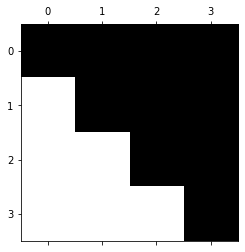

In [26]:
print(tabulate(hp_value.round(0)))
#DF = pd.DataFrame(hp_value)
#DF.to_csv("1231_hp_value_0304.csv")
plt.spy(hp_value)

-----  -----  -----  -----
11298  15101  22255  33201
    0   9972  10800  14918
    0      0  10800  11100
    0      0      0  11100
-----  -----  -----  -----


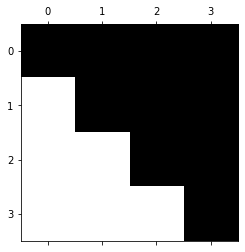

In [22]:
plt.spy(cb_value)
print(tabulate(cb_value.round(0)))
#DF = pd.DataFrame(cb_value)
#DF.to_csv("1231_cb_value_0304.csv")

----  ----  -----  -----
3879  9291  22255  33201
   0     0      0  14918
   0     0      0      0
   0     0      0      0
----  ----  -----  -----


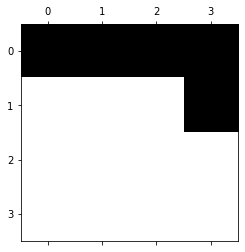

In [23]:
print(tabulate(eq_value.round(0)))
plt.spy(eq_value)

----  ----  -----  -----
7419  5810      0      0
   0  9972  10800      0
   0     0  10800  11100
   0     0      0  11100
----  ----  -----  -----


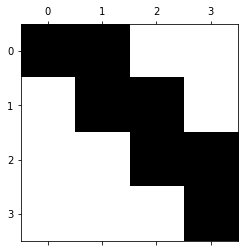

In [24]:
print(tabulate(db_value.round(0)))
plt.spy(db_value)

In [159]:
#print(tabulate(cb_value.round(0)))

In [47]:
"""
dt = T/N

q = (np.exp(rf*dt) - d)/(u-d)
disc = np.exp(-rf*dt)


# option payoff 
call_prices = np.zeros( (N+1, N+1) )
for j in range(0, N+1):
    C[j] = max(0, S[j] - K)
    
# backward recursion through the tree
for i in np.arange(N-1,-1,-1):
    for j in range(0,i+1):
        S = S0 * u**j * d**(i-j)
        C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
        if opttype == 'P':
            C[j] = max(C[j], K - S)
        else:
            C[j] = max(C[j], S - K)
"""

"\ndt = T/N\n\nq = (np.exp(rf*dt) - d)/(u-d)\ndisc = np.exp(-rf*dt)\n\n\n# option payoff \ncall_prices = np.zeros( (N+1, N+1) )\nfor j in range(0, N+1):\n    C[j] = max(0, S[j] - K)\n    \n# backward recursion through the tree\nfor i in np.arange(N-1,-1,-1):\n    for j in range(0,i+1):\n        S = S0 * u**j * d**(i-j)\n        C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )\n        if opttype == 'P':\n            C[j] = max(C[j], K - S)\n        else:\n            C[j] = max(C[j], S - K)\n"

In [5]:
def american_fast_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise stock prices at maturity
    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        
    # option payoff 
    if opttype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]
        if opttype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
                
    return C[0]

american_fast_tree(K,T,S0,r,N,u,d,opttype='P')

4.654588754602527